### Dataset preparation

In [1]:
### Load necessary modules -------------------------------
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

# Other
from mltools import classification_tools as CT
from mltools import model_tools as MT

In [2]:
df = pd.read_csv('fico.csv')
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156 entries, 0 to 4155
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ExternalRiskEstimate          4156 non-null   float64
 1   NetFractionRevolvingBurden    4146 non-null   float64
 2   AverageMInFile                4156 non-null   float64
 3   MSinceOldestTradeOpen         4128 non-null   float64
 4   PercentTradesWBalance         4110 non-null   float64
 5   PercentInstallTrades          4156 non-null   float64
 6   NumSatisfactoryTrades         4147 non-null   float64
 7   NumTotalTrades                4139 non-null   float64
 8   PercentTradesNeverDelq        4156 non-null   float64
 9   MSinceMostRecentInqexcl7days  4086 non-null   float64
 10  RiskPerformance               4156 non-null   float64
dtypes: float64(11)
memory usage: 357.3 KB


In [3]:
# Pasar la variable RiskPerformance a int64
df['RiskPerformance'] = df['RiskPerformance'].astype('int64')
# Put the column RiskPerformance as a category
df['RiskPerformance'] = df['RiskPerformance'].astype('category')
# Change RiskPerformance values, if they are 1 to True and if they are 0 to False
df['RiskPerformance'] = df['RiskPerformance'].replace({1: 'Yes', 0: 'No'})

In [4]:
df.dropna(inplace=True)
# Drop the column called NumTotalTrades
df.drop(columns='NumTotalTrades', inplace=True)

In [5]:
# Define input and output matrices
INPUTS = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 'MSinceOldestTradeOpen', 'PercentTradesWBalance',
       'PercentInstallTrades', 'NumSatisfactoryTrades', "NumTotalTrades",
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days']
OUTPUT = 'RiskPerformance'

X = df[INPUTS]
Y = df[OUTPUT]

# Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=2023, #seed for replication
                                                    stratify = Y)   #Preserves distribution of y. Same proportion. useful for classification but not for regression problemas

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['RiskPerformance'] = Y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['RiskPerformance'] = Y_test # We will call Y as output variable for simplicity


## Training linear model

In [6]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR = INPUTS

#ModLogReg = LogisticRegression()
LogReg_fit = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                        ('LogReg',LogisticRegression(penalty=None))]) # Model to use in the pipeline

#Train model
LogReg_fit.fit(X_train[INPUTS_LR], Y_train);

print("Logistic Regression Trained")

Logistic Regression Trained


In [7]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit, X_train[INPUTS_LR], Y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.7319305613059679

In [8]:
CT.summaryLogReg(LogReg_fit, X_train[INPUTS_LR], Y_train)

Deviance Residuals:
       Min        1Q    Median        3Q       Max
0 -0.98337 -0.331903  0.059445  0.323226  0.969099

Coefficients:
                              Estimate
Intercept                     0.054622
ExternalRiskEstimate         -0.705229
NetFractionRevolvingBurden    0.274141
AverageMInFile               -0.325440
MSinceOldestTradeOpen         0.100231
PercentTradesWBalance         0.054129
PercentInstallTrades          0.101887
NumSatisfactoryTrades        -0.263562
PercentTradesNeverDelq       -0.151815
MSinceMostRecentInqexcl7days -0.312459
                              Estimate  Std. Err   t-value      Pr(>|t|)  \
Intercept                     0.054622  0.041385  1.319839  1.868889e-01   
ExternalRiskEstimate         -0.705229  0.075189 -9.379389  0.000000e+00   
NetFractionRevolvingBurden    0.274141  0.062020  4.420185  9.861644e-06   
AverageMInFile               -0.325440  0.071401 -4.557936  5.165886e-06   
MSinceOldestTradeOpen         0.100231  0.065844  1.52

In [9]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_pred'] = LogReg_fit.predict(X_train[INPUTS_LR])
dfTR_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,0]
dfTR_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LR_pred'] = LogReg_fit.predict(X_test)
dfTS_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,0]
dfTS_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,1]

#visualize evaluated data
dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,RiskPerformance,Y_LR_pred,Y_LR_prob_neg,Y_LR_prob_pos
1605,83.0,0.0,50.0,157.0,20.0,53.0,13.0,93.0,3.0,No,No,0.670061,0.329939
524,81.0,34.0,75.0,183.0,40.0,44.0,45.0,100.0,0.0,No,No,0.756587,0.243413
2994,68.0,25.0,34.0,81.0,65.0,32.0,25.0,100.0,2.0,No,Yes,0.411696,0.588304
103,60.0,35.0,25.0,49.0,72.0,32.0,24.0,100.0,0.0,Yes,Yes,0.221349,0.778651
4112,59.0,78.0,52.0,147.0,100.0,71.0,5.0,86.0,12.0,Yes,Yes,0.149253,0.850747


In [10]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LR_pred'],labels=['Yes', 'No'])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference  Yes   No
      Yes 1208  417
       No  436 1121

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.46
Mcnemar's Test P-Value: 0.54
Sensitivity: 0.72
Specificity: 0.74
Precision: 0.73
Recall: 0.74
Prevalence: 0.49
Detection Rate: 0.35
Detection prevalence: 0.48
Balanced accuracy: 0.73
F1 Score: 0.74
Positive label: Yes


In [11]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LR_pred'],labels=['Yes','No'])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
Reference  Yes  No
      Yes  310  96
       No   99 291

Accuracy: 0.76
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.51
Mcnemar's Test P-Value: 0.89
Sensitivity: 0.75
Specificity: 0.76
Precision: 0.76
Recall: 0.76
Prevalence: 0.49
Detection Rate: 0.37
Detection prevalence: 0.49
Balanced accuracy: 0.75
F1 Score: 0.76
Positive label: Yes


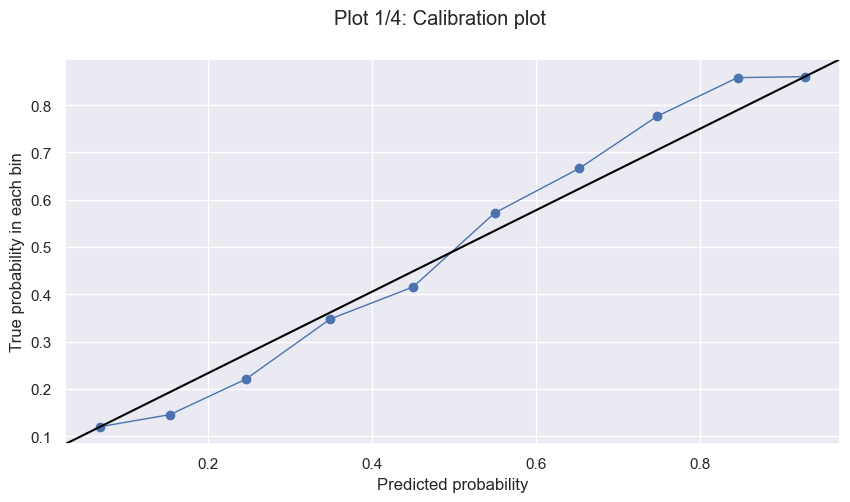

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


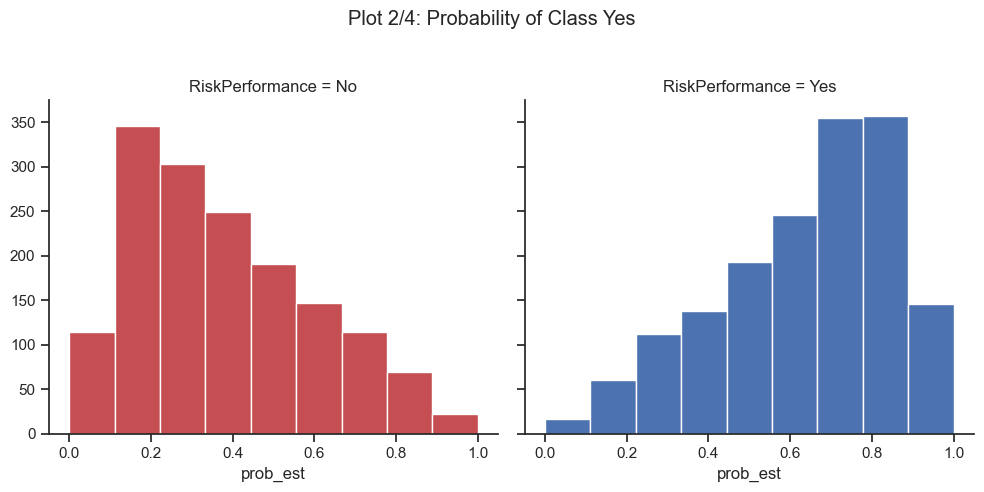

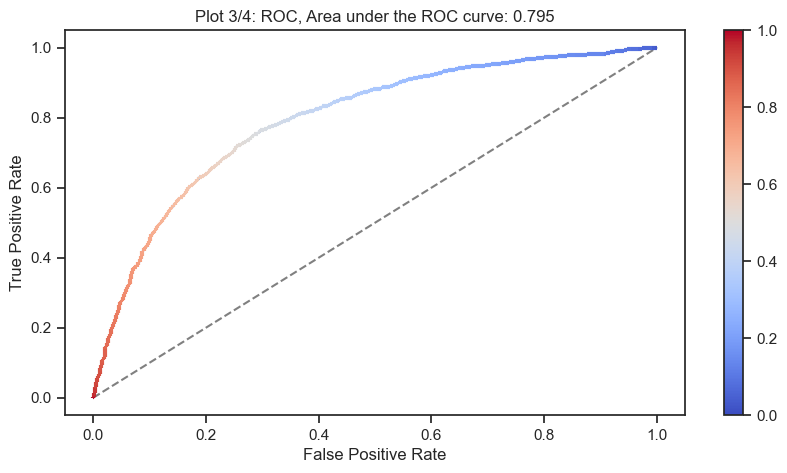

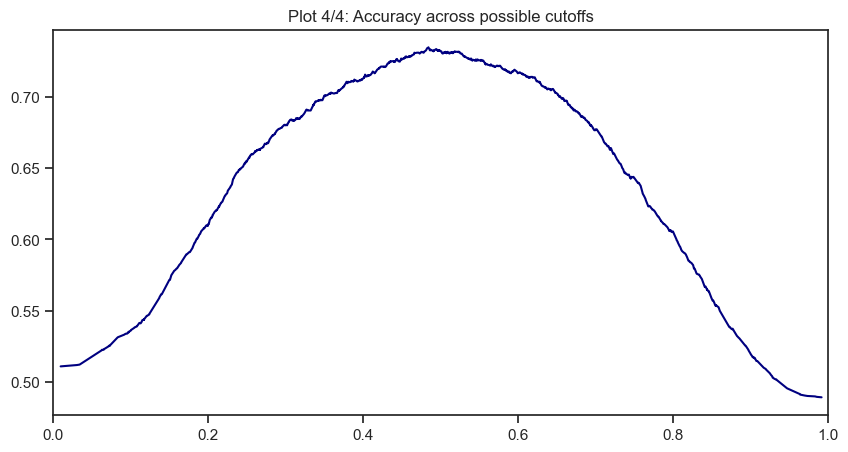

In [12]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], LogReg_fit.predict_proba(X_train[INPUTS_LR]), selClass='Yes')

## Non-linea model

In [13]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR2_NUM = ['ExternalRiskEstimate','NetFractionRevolvingBurden','AverageMInFile','MSinceOldestTradeOpen', 'PercentTradesWBalance',
       'PercentInstallTrades', 'NumSatisfactoryTrades']
INPUTS_LR2_SQ = ['PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days']
INPUTS_LR2 =   INPUTS_LR2_NUM + INPUTS_LR2_SQ

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the numeric variables by scaling
square_transformer = Pipeline(steps=[('scaler', StandardScaler()),
                                      ('Poly',PolynomialFeatures())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_LR2_NUM),
        ('sq', square_transformer, INPUTS_LR2_SQ),
        ])

pipe = Pipeline(steps=[('Prep',preprocessor), # Preprocess the variables when training the model 
                       ('LogReg',LogisticRegression(fit_intercept=False, penalty=None))]) # Avoid using intercept when using polynomial features

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 15
param = {}
LogReg_fit_sq = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 
#Train model
LogReg_fit_sq.fit(X_train[INPUTS_LR2], Y_train)

print("Logistic Regression Trained")

Logistic Regression Trained


In [14]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit_sq, X_train[INPUTS_LR2], Y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.730360205831904

In [92]:
CT.summaryLogReg(LogReg_fit_sq.best_estimator_, X_train[INPUTS_LR2], Y_train)

Deviance Residuals:
        Min       1Q    Median        3Q       Max
0 -0.970965 -0.32353  0.064145  0.315002  0.950075

Coefficients:
                                                    Estimate
ExternalRiskEstimate                               -0.641947
NetFractionRevolvingBurden                          0.284172
AverageMInFile                                     -0.346333
MSinceOldestTradeOpen                               0.096020
PercentTradesWBalance                               0.072065
PercentInstallTrades                                0.094309
NumSatisfactoryTrades                              -0.316055
NumTotalTrades                                      0.075183
1                                                  -0.044627
PercentTradesNeverDelq                             -0.332604
MSinceMostRecentInqexcl7days                       -0.716936
PercentTradesNeverDelq^2                           -0.073869
PercentTradesNeverDelq MSinceMostRecentInqexcl7... -0.087009
MSinceMos

In [93]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_sq_pred'] = LogReg_fit_sq.predict(X_train[INPUTS_LR2])
dfTR_eval['Y_LR_sq_prob_neg'] = LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2])[:,0]
dfTR_eval['Y_LR_sq_prob_pos'] = LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LR_sq_pred'] = LogReg_fit_sq.predict(X_test[INPUTS_LR2])
dfTS_eval['Y_LR_sq_prob_neg'] = LogReg_fit_sq.predict_proba(X_test[INPUTS_LR2])[:,0]
dfTS_eval['Y_LR_sq_prob_pos'] = LogReg_fit_sq.predict_proba(X_test[INPUTS_LR2])[:,1]

#visualize evaluated data
dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,RiskPerformance,Y_LR_pred,Y_LR_prob_neg,Y_LR_prob_pos,Y_LR_sq_pred,Y_LR_sq_prob_neg,Y_LR_sq_prob_pos
1605,83.0,0.0,50.0,157.0,20.0,53.0,13.0,15.0,93.0,3.0,No,No,0.669544,0.330456,No,0.698899,0.301101
524,81.0,34.0,75.0,183.0,40.0,44.0,45.0,45.0,100.0,0.0,No,No,0.758794,0.241206,No,0.739244,0.260756
2994,68.0,25.0,34.0,81.0,65.0,32.0,25.0,25.0,100.0,2.0,No,Yes,0.413814,0.586186,Yes,0.463194,0.536806
103,60.0,35.0,25.0,49.0,72.0,32.0,24.0,25.0,100.0,0.0,Yes,Yes,0.221467,0.778533,Yes,0.221282,0.778718
4112,59.0,78.0,52.0,147.0,100.0,71.0,5.0,7.0,86.0,12.0,Yes,Yes,0.149563,0.850437,Yes,0.160105,0.839895


In [95]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LR_sq_pred'],labels=['Yes', 'No'])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference  Yes  No
      Yes  304 102
       No  102 288

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.49
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.74
Specificity: 0.75
Precision: 0.75
Recall: 0.75
Prevalence: 0.49
Detection Rate: 0.36
Detection prevalence: 0.49
Balanced accuracy: 0.74
F1 Score: 0.75
Positive label: Yes


In [96]:
#Confusion matrix for Log Reg Model
print("----- Test CONFUSION MATRIX -----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LR_sq_pred'],labels=['Yes', 'No'])

----- Test CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference  Yes  No
      Yes  304 102
       No  102 288

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.49
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.74
Specificity: 0.75
Precision: 0.75
Recall: 0.75
Prevalence: 0.49
Detection Rate: 0.36
Detection prevalence: 0.49
Balanced accuracy: 0.74
F1 Score: 0.75
Positive label: Yes


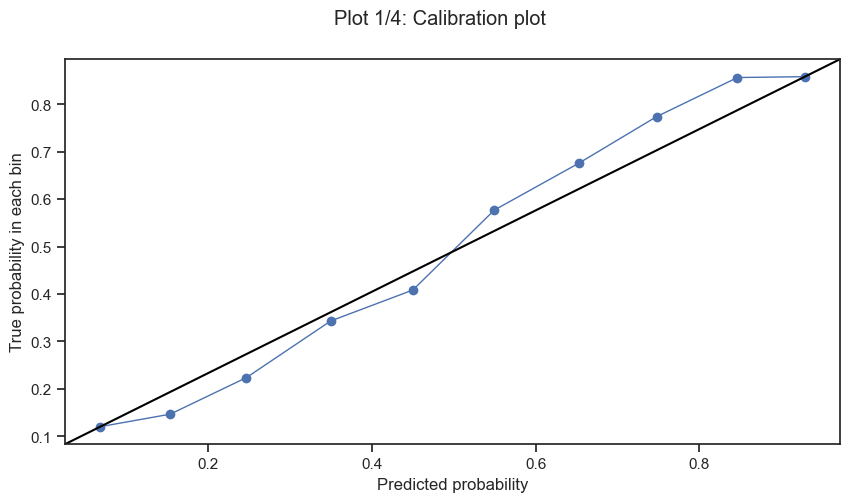

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


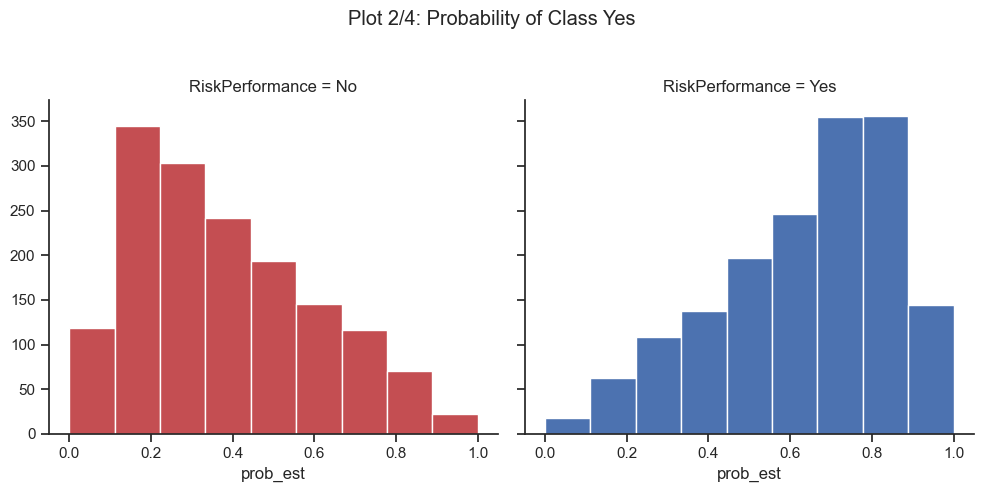

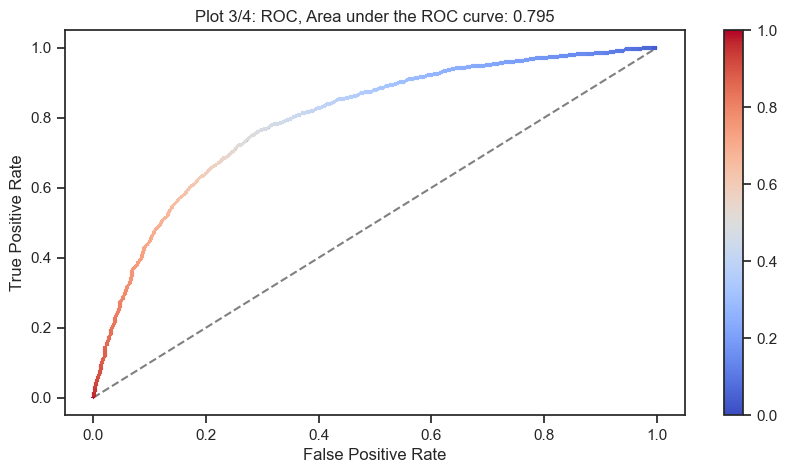

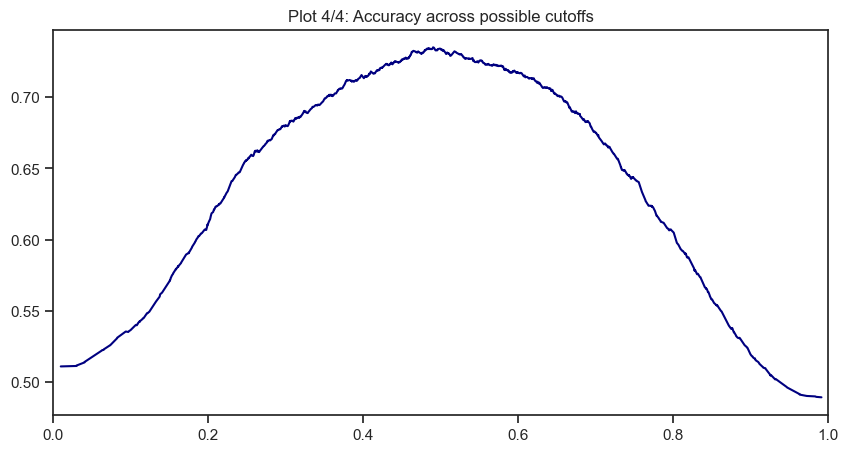

In [97]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], LogReg_fit.predict_proba(X_train[INPUTS_LR2]), selClass='Yes')